In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import brier_score_loss, accuracy_score
from sklearn.calibration import calibration_curve

from tennis_model_predict import get_model_win_proba

from tennis_model_predict import general_elo_dict, hard_dict, ts_dict

from trueskillthroughtime import Game, Player

from elo_funcs import elo_predict

C:\Users\jyoung\Projects\tennis_project\tennis_model_predict.py:54: DtypeWarning: Columns (8,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{data_folder}/processed_apt_with_ts.csv', parse_dates=['tourney_date'])


In [2]:
def true_skill_win_proba(player_1=None, player_2=None):

  player_1 = Player(ts_dict[player_1][-1][1])
  player_2 = Player(ts_dict[player_2][-1][1])

  return Game([[player_1], [player_2]]).evidence

In [8]:
get_model_win_proba(player_1='Hubert Hurkacz',
                    player_2='Dominic Thiem',
                    surface='Hard',
                    tourney_level='A',
                    round_=3)

0.75902975

In [173]:
player_pairs = [['Duje Ajdukovic', 'Henri Squire', 2.25, 1.57],
                ['Jonas Forejtek', 'Salvatore Caruso', 1.61, 2.2],
                ['Rudolf Molleker', 'Alexander Ritschard', 2.75, 1.4],
                ['Jorge Brian Panta Herreros', 'Colin Markes', 1.26, 3.6],
                ['Calvin Hemery', 'Mark Lajal', 2.23, 1.61],
                ['Jules Marie', 'Yanki Erel', 1.39, 2.86],
                ['Terence Atmane', 'David Poljak', 1.75, 1.98]]

In [174]:
def get_tourney_predictions(matches=None, tourney_surface=None, tourney_level=None,
                            tourney_round=None):


    match_number = np.random.randint(1, 100000, 1)[0]

    probas = []

    for pair in matches:
        proba = get_model_win_proba(player_1=pair[0],
                                    player_2=pair[1],
                                    surface=tourney_surface,
                                    tourney_level=tourney_level,
                                    round_=tourney_round)

        p1_ml_wp = 1/pair[2]
        p2_ml_wp = 1/pair[3]
        sum_wp = p1_ml_wp + p2_ml_wp

        p1_implied_wp = p1_ml_wp / sum_wp
        p2_implied_wp = p2_ml_wp / sum_wp

        p1_kelly = proba - ((1 - proba) / (pair[2] - 1))
        p2_kelly = (1 - proba) - (proba / (pair[3] - 1))

        probas.append([pair[0],
                       match_number,
                       proba, 
                       round(p1_implied_wp, 2),
                       max(p1_kelly, 0)]
                     )

        probas.append([pair[1],
                       match_number,
                       1 - proba,
                       round(p2_implied_wp, 2), 
                       max(p2_kelly, 0)]
                     )

        match_number += 1

    pred_df = (
        pd.DataFrame
        .from_records(probas, columns=['player', 'match_id', 'model_pred', 'ml_wp', 'kelly_bet'])
    )
    
    pred_df['surface'] = tourney_surface
    pred_df['tier'] = tourney_level
    
    return pred_df

In [175]:
latest_df = get_tourney_predictions(matches=player_pairs,
                                          tourney_surface='Hard',
                                          tourney_level='C',
                                          tourney_round=3)

latest_df['result'] = [1, 0, 1, 0, 0, 1,1, 0, 0, 1, 1, 0, 0, 1]

In [176]:
old_df = pd.read_csv(r'C:\Users\jyoung\Projects\tennis_project\model_moneyline_comparison.csv')


overall_df = pd.concat([old_df, latest_df])

In [177]:
overall_df.tail(6)

,player,match_id,model_pred,ml_wp,kelly_bet,surface,tier,result
8,Calvin Hemery,8981,0.434886,0.42,0.000000,Hard,C,0
9,Mark Lajal,8981,0.565114,0.58,0.000000,Hard,C,1
10,Jules Marie,8982,0.608912,0.67,0.000000,Hard,C,1
11,Yanki Erel,8982,0.391088,0.33,0.063715,Hard,C,0
12,Terence Atmane,8983,0.708422,0.53,0.319651,Hard,C,0
13,David Poljak,8983,0.291578,0.47,0.000000,Hard,C,1


In [185]:

print('moneyline brier:', brier_score_loss(overall_df['result'], overall_df['ml_wp']))
print('model brier:', brier_score_loss(overall_df['result'], overall_df['model_pred']))

print('moneyline accuracy:', accuracy_score(overall_df['result'], overall_df['ml_wp'].round(0)))
print('model accuracy:', accuracy_score(overall_df['result'], overall_df['model_pred'].round(0)))

moneyline brier: 0.17762972972972974
model brier: 0.19337698658505564
moneyline accuracy: 0.7702702702702703
model accuracy: 0.7297297297297297


In [107]:
overall_df['model_pred'] = np.where(overall_df['model_pred'].between(0.51, 0.6), 0.6, overall_df['model_pred'])
overall_df['model_pred'] = np.where(overall_df['model_pred'].between(0.49, 0.4), 0.4, overall_df['model_pred'])

In [109]:
top10 = overall_df.sort_values(by='kelly_bet', ascending=False).head(10)
top10

,player,match_id,model_pred,ml_wp,kelly_bet,surface,tier,result
29,Tommy Paul,29552,0.978643,0.88,0.711683,Hard,A,1
18,Pedro Cachin,29547,0.893541,0.62,0.692676,Hard,A,1
37,Bernabe Zapata Miralles,29556,0.765311,0.25,0.679970,Hard,A,1
42,Marco Trungelliti,29559,0.809644,0.59,0.497584,Hard,A,0
102,Pavel Kotov,29589,0.818088,0.61,0.493244,Hard,A,0
101,Antoine Bellier,29588,0.824636,0.64,0.451520,Hard,A,1
96,Jason Kubler,29586,0.842925,0.72,0.440169,Hard,A,1
109,Richard Gasquet,29592,0.653501,0.38,0.422502,Hard,A,1
48,Ilya Ivashka,29562,0.942490,0.85,0.419676,Hard,A,1
3,Facundo Bagnis,75789,0.930591,0.84,0.352185,Clay,C,1


In [154]:
for x in ts_dict.keys():
    if 'Bueno' in x:
        print(x)

Alejandro Augusto Bueno
Jaime Ignacio Bueno Tapia
Gonzalo Bueno


In [184]:
overall_df[overall_df['model_pred'].between(0.8, 0.9)]

,player,match_id,model_pred,ml_wp,kelly_bet,surface,tier,result
10,Stefanos Tsitsipas,7169,0.883203,0.81,0.153224,Hard,A,1
18,Pedro Cachin,7173,0.893541,0.62,0.692676,Hard,A,1
42,Marco Trungelliti,7185,0.809644,0.59,0.497584,Hard,A,0
52,Tim Van Rijthoven,7190,0.824422,0.84,0.000000,Hard,A,1
54,Roman Safiullin,7191,0.818571,0.83,0.000000,Hard,A,0
78,Tim Van Rijthoven,7203,0.893437,0.82,0.227421,Hard,A,1
83,Jesper De Jong,7205,0.850694,0.86,0.000000,Hard,A,1
96,Jason Kubler,7212,0.842925,0.72,0.440169,Hard,A,1
101,Antoine Bellier,7214,0.824636,0.64,0.451520,Hard,A,1
102,Pavel Kotov,7215,0.818088,0.61,0.493244,Hard,A,0


<AxesSubplot: ylabel='Frequency'>

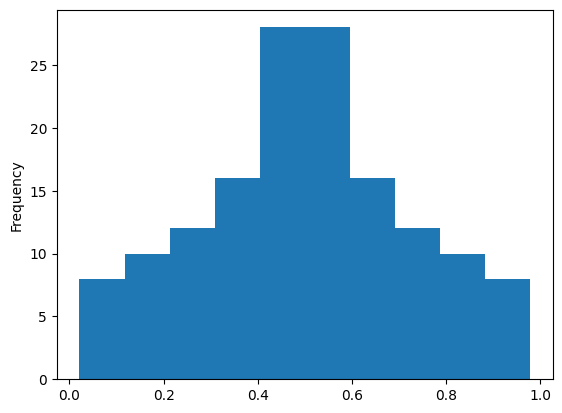

In [179]:
overall_df['model_pred'].plot(kind='hist')

<AxesSubplot: ylabel='Frequency'>

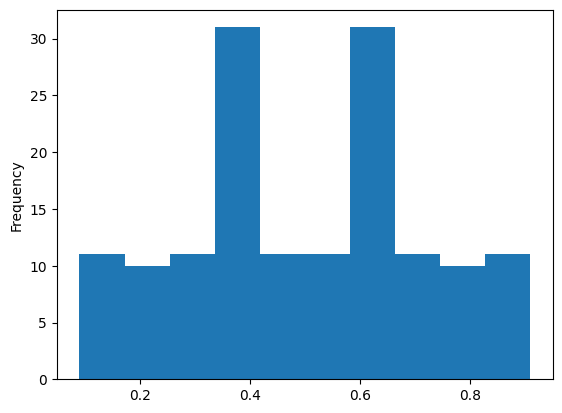

In [180]:
overall_df['ml_wp'].plot(kind='hist')

In [181]:
x, y = calibration_curve(results, overall_df['ml_wp'], n_bins=10)

sns.scatterplot(x=x, y=y)

ValueError: Found input variables with inconsistent numbers of samples: [134, 148]

In [183]:
overall_df.to_csv('model_moneyline_comparison.csv', index=False)